# Lab2. Pytorch Regression (Linear Regression vs MLP)  

이 실습에서는 Regression Problem을 `pytorch`로 해결해볼 겁니다! 두가지 모델(Linear Regression, MLP)을 둘 다 구현해보고 실제로 모델이 생각하는 데이터 분포를 시각화해서 MLP가 가지는 엄청난 non-linearity learning ability를 직접 살펴보는게 본 실습의 묘미입니다.


**이 문서를 구글 Colab에서 쉽게 실행해보는법**  
1. [제가 미리 만들어놓은 이 링크](https://colab.research.google.com/github/heartcored98/Standalone-DeepLearning/blob/master/Lec2/Lab2_pytorch_regression_demo.ipynb)를 눌러 본 .ipynb 파일을 구글 Colab에서 바로 열 수 있습니다. 이때 구글에 로그인을 해야 합니다.
2. 아무 셀이나 선택한 후 `Ctrl+Enter`를 눌러 실행해보면 **[경고: 이 노트는 Google에서 작성하지 않았습니다]**라고 뜨는데 `실행 전에 모든 런타임 재설정`을 선택한 채로 `무시하고 계속하기`를 눌러줍니다.  
3. **[모든 런타임 재설정]** 이 뜰 텐데 `예`를 눌러줍니다.  
4. 잠시 구글 서버의 배치가 되면서 우상단에 `연결중` -> `초기화중` -> `연결됨`이 뜨면서 실행이 가능한 상태가 됩니다.  

**이 문서를 구글 Colab에서 어렵게 실행해보는법**  
1. 구글 Colab 문서를 하나 만들어줍시다. 
2. 본 문서에 있는 셀에 있는 코드를 드래그 한 후 `Ctrl+C`를 눌러줍시다.  
3. 구글 Colab 문서에 가서 `Ctrl+V`를 눌러줍시다.
4. 모든 셀이 다 복사될 때까지 1~3 무한반복!  

**구글 Colab에서 실습후 저장하는법**  
**쉽게 실행보는법**을 따라오셨다면 Colab에서 임시 노트북으로 열리기 때문에 `파일`->`드라이브로 저장`을 눌러서 여러분의 구글 드라이브에 저장하거나 `파일` -> `.ipynb 다운로드`를 눌러서 다운로드 해줍시다.   

*Written by. 조재영(whwodud9@kaist.ac.kr) 2019.01.20 *

### Install Pytorch (For Google Colab)

In [ ]:
import torch
print(torch.__version__)

1.10.0+cu111


In [ ]:
"""pip install -q torch==1.0.0 torchvision
import torch
print(torch.__version__)"""

'pip install -q torch==1.0.0 torchvision\nimport torch\nprint(torch.__version__)'

### 1. Data Generation  (Preparation)

Regression 실습에 사용할 데이터를 만들어봅시다. 이번에는 X가 2차원 Y가 1차원인 상황입니다.  
아래 관계를 따르는 데이터 분포가 있으며 관측시 발생한 오차가 $e$가 더해져 있다고 합시다.  
$sin(x)$ 함수와 $log(x)$ 함수 모두 쉽게 생각할 수 있는 non-linear 함수이죠!  

$$ e \sim \mathcal{N} (0, 0.5) $$
$$y = \ 2 sin(x_1) + log({1 \over 2}x_2^2) + e$$  


**Data Set**  
$$X_{train} \in \mathcal{R}^{1600 \times 2}, Y_{train} \in \mathcal{R}^{1600}$$  
$$X_{val} \in \mathcal{R}^{400 \times 2}, Y_{val} \in \mathcal{R}^{400}$$  
$$X_{test} \in \mathcal{R}^{400 \times 2}, Y_{test} \in \mathcal{R}^{400}$$

X, Y 데이터를 3D 공간에 시각화 해볼까요?  
`numpy`의 `random.rand()` 함수를 사용하면 n개의 랜덤 샘플을 0~1의 uniform distribution에서 샘플링할 수 있습니다.

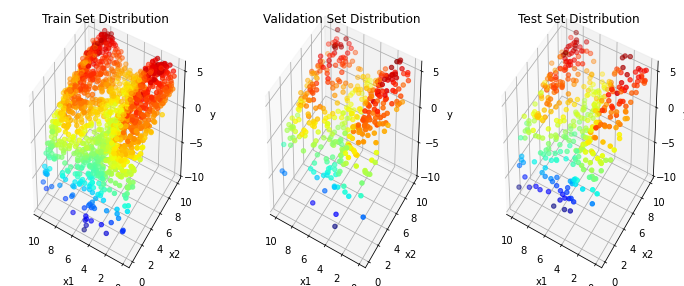

In [ ]:
#x가 2차원인 데이터를 만듦
#y는 관찰한 데이터

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

# ====== Generating Dataset ====== #
num_data = 2400 #2400개의 데이터를 만들거다.
x1 = np.random.rand(num_data) * 10
x2 = np.random.rand(num_data) * 10 #10배를 곱했으니까 0에서 10까지 균일분포에서 샘플링
e = np.random.normal(0, 0.5, num_data) #에러항은 mu가 0, std가 0.5인 가우시안 분포에서 데이터를 뽑음
X = np.array([x1, x2]).T #전치를 하는 이유는 x1, x2를 옆으로 합치고 싶어서 (2400x2 짜리 x를 만들괴싶어서)
#print(X.shape) 2x2400 ->2400x2
#우리는 첫 번째 demension 값이 우리가 가지고 있는 sample의 갯수가 되기를 원한다.
#왜냐면 pytorch들이 맨 첫번째 행렬은 sample의 갯수를 받도록 디자인되어 있어서
y = 2*np.sin(x1) + np.log(0.5*x2**2) + e #위에서 쓴 y대로 데이터 분포가 완성됨

# ====== Split Dataset into Train, Validation, Test ======#
# 데이터를 외워버린건지, 정말로 경향성을 잘 이해하고 있는건지 평가할 수 없다.
# 그래서 train, validation, test 데이터셋을 나눈다.
train_X, train_y = X[:1600, :], y[:1600] 
val_X, val_y = X[1600:2000, :], y[1600:2000]
test_X, test_y = X[2000:, :], y[2000:]

# ====== Visualize Each Dataset ====== # 
fig = plt.figure(figsize=(12,5)) 
# plt를 사용할 수 있는 방법이 2가지 흐름으로 나뉨
# plt로 다이렉트로 plt.plot(x,y) : 그래프를 하나만 그릴 때
# 여러개의 그래프를 만들 때는 figure을 먼저 만들고 figsize도 정해준다.
# 이 figure이란건 3개가 그러져 있는 전체 캔버스를 말한다.
# subplot은 figure이라는 전체 캔버스 안에 들어갈 작은 각각의 그래프를 말한다.

ax1 = fig.add_subplot(1, 3, 1, projection='3d')#row가 1개, column이 3개의 grid, 1번째칸/ 3d그림을 그리기위해
ax1.scatter(train_X[:, 0], train_X[:, 1], train_y, c=train_y, cmap='jet')
#train_X[:, 0]: x1값들을 주루룩 넣음
#train_X[:, 1]: x2값들을 주루룩 넣음
#y는 1차원이라 그냥 바로 넣음
#c는 색을 지정하는 option.
#cmap으로 여러 컬러바를 고를 수 있다. 

ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
ax1.set_zlabel('y')
ax1.set_title('Train Set Distribution')
ax1.set_zlim(-10, 6) #z축의 범위를 설정해주는 값
ax1.view_init(40, -60) #3d라서 쓰는 옵션. 각도를 바꿔줄 수 있다. 
ax1.invert_xaxis() #x축을 바뀌는걸 보여줌.(왜냐면 0,0으로 시작하면 좋겠어서.)

# overfitting을 방지하기 위한 validation set
ax2 = fig.add_subplot(1, 3, 2, projection='3d')
ax2.scatter(val_X[:, 0], val_X[:, 1], val_y, c=val_y, cmap='jet')

ax2.set_xlabel('x1')
ax2.set_ylabel('x2')
ax2.set_zlabel('y')
ax2.set_title('Validation Set Distribution')
ax2.set_zlim(-10, 6)
ax2.view_init(40, -60)
ax2.invert_xaxis()

ax3 = fig.add_subplot(1, 3, 3, projection='3d')
ax3.scatter(test_X[:, 0], test_X[:, 1], test_y, c=test_y, cmap='jet')

ax3.set_xlabel('x1')
ax3.set_ylabel('x2')
ax3.set_zlabel('y')
ax3.set_title('Test Set Distribution')
ax3.set_zlim(-10, 6)
ax3.view_init(40, -60)
ax3.invert_xaxis()

plt.show()

Q. Training validation 순서

validation으로 validation을 하는 건 기호에 맞게 할 수 있다.
training n번 하고 validation 1번
n은 자유. 상황에 맞게 조절할 수 있다.


### 2. Hypothesis Define (Model Define)  

Linear Regression 시에 활용하는 H(x) = Wx + b를 파이토치로 구현할 때는 단순하게 `nn.Linear` 모듈을 하나 만들어주면 됩니다. 이 때`in_features`는 x의 차원이고, `out_features`는 y의 차원입니다.  


**Linear Model**   
$$H = \ XW + b \ \ ( W \in \mathcal{R}^{2 \times 1}, b \in \mathcal{R}^{1}, H \in \mathcal{R}^{N \times 1})$$


**MLP Model**
$$Let \ relu(X) = \ max(X, 0)$$  

$$h = \ relu(X W_1 + b_1) \ \  ( W_1 \in \mathcal{R}^{2 \times 200}, b_1 \in \mathcal{R}^{200}, h \in \mathcal{R}^{N \times 200})$$  

$$H = \ h W_2 + b_2  \ \  ( W_2 \in \mathcal{R}^{200 \times 1}, b_2 \in \mathcal{R}^{1}, H \in \mathcal{R}^{N  \times 1})$$

input 이 2차원이었는데 거기에 w를 곱해서 (output으로 하고자 하는) 1차원으로 만들고 거기에 약간의 bias를 더함

In [ ]:
import torch
import torch.nn as nn

# 가장 기본적인 인공 신경망

class LinearModel(nn.Module): #LinearModel 이라는 클래스는 nn.Module이라는 다른 클래스를 상속하겠다. 
#우리는 정말 순수하게 하이퍼시스의 구성 부분만 집중할 수 있다. 
    def __init__(self): # init함수는 생성할 때 딱 한번 실행되는 함수
        super(LinearModel, self).__init__() #python에서 쓰이는 문법인데 상속을 하고나면 꼭 써줘야 하는 문법이다.(그냥 규칙) 
        self.linear = nn.Linear(in_features=2, out_features=1, bias=True) 
        #클래스에서 계속 contain하고 있을 변수인 nn.Linear하나를 만들었음(wx+b)
        #내부에서 자동으로 w= 2*1, b=1짜리 파라미터를 랜덤으로 초기화해준다.
        #bias = True로 하면 b가 있고 False로 하면 그냥 wx로 함(cnn에서는 bias 없이 필터를 쓰기도 함)
    
    # forward는 꼭 지켜서 써야 하는 함수이다.
    # 다른 명칭으로 바꾸면 pytorch가 인식할 수 없음
    # 모델에 x가 들어왔을 때 이 x를 어떻게 계산해서 y를 만들건지를 써주는 부분
    def forward(self, x):
    # 인스턴스(샘플) x가 인풋으로 들어왔을 때 모델이 예측하는 y값을 리턴합니다.
        return self.linear(x)
    
#9번 강의 내용    
class MLPModel(nn.Module):
    def __init__(self, in_dim, out_dim, hid_dim): 
        super(MLPModel, self).__init__()
        self.linear1 = nn.Linear(in_dim, hid_dim) #2차원 데이터, hidden layer의 unit 수 200
        self.linear2 = nn.Linear(hid_dim, out_dim) #200을 다시 1차원으로
        self.relu = nn.ReLU()
        #linear 층 2개 만들고 nonlinear(활성함수)층 하나 만듦
    
    def forward(self, x):
    # 인스턴스(샘플) x가 인풋으로 들어왔을 때 모델이 예측하는 y값을 리턴합니다.
        x = self.linear1(x)
        x = self.relu(x) #비선형 함수 통과
        x = self.linear2(x)
        return x

lm = LinearModel()
print(lm.linear.weight) #이렇게 값을 직접 확인할 수 있다.
print(lm.linear.bias) #nn.linear 모듈이 이렇게 알아서 파라미터를 초기화 해줌

m = MLPModel(2,1,200)

Parameter containing:
tensor([[-0.5830,  0.2288]], requires_grad=True)
Parameter containing:
tensor([-0.6159], requires_grad=True)


### 3. Cost Function Define (Loss Function Define)  

Regression Problem 에서의 Loss Function을 작성해봅시다.  
파이토치의 `nn` 아래에는 다양한 Loss Function이 이미 구현되어 있습니다.  
[여기](https://pytorch.org/docs/stable/_modules/torch/nn/modules/loss.html)에서 파이토치 내부에 구현되어 있는 MSE, Cross-Entropy, KL-Divergence 등을 확인할 수 있습니다.  
이 실습에서는 Regression Problem 이므로 Mean Squared Error 즉 MSE Loss를 써봅시다.

In [ ]:
reg_loss = nn.MSELoss()

#uncomment for testing Loss Function
test_pred_y = torch.Tensor([0,0,0,0]) #가상의 예측 y
test_true_y = torch.Tensor([0,1,0,1]) #가상의 실제 y
#torch의 연산을 활용할거면 무조건 다 torch.tensor로 감싸서 형변환
#예상되는 값이 나오는지 확인해보자

print(reg_loss(test_pred_y, test_true_y)) #2 / 4 = 0.5
print(reg_loss(test_true_y, test_true_y)) #100프로로 예측한거니까 0이 나와야함

#나중에 처음 보는 loss 클래스도 간단하게 검토해보면 편안

tensor(0.5000)
tensor(0.)


### 4. Train & Evaluation
이제 모델도 정의했고 Loss Function도 정의했으니 한번 학습시켜볼까요?  
저번에는 저희가 직접 파라미터(w 하나)에 따른 loss의 편미분을 유도하고 거기서 나온 그라디언트로 w를 업데이트했는데요.  
`pytorch`에서는 loss.backward() 라는 기능을 쓰면 알아서 loss를 계산되는데 사용한 각 파라미터에 대한 loss의 편미분을 계산해줍니다.  
이후 `optimizer.step()` 함수를 사용하면 각 파라미터의 그라디언트를 바탕으로 파라미터의 값을 조금씩 업데이트 해줍니다. 

이 때 모델은 매 Iteration 때마다 Train Set에 의해 학습되면서 동시에 Validation Set을 넣고 Loss를 비교하게됩니다. 
그리고 저희가 평가하고 싶은 때마다 (지금은 200번) Test Set을 넣고 Visualize 하는데 필요한 Predicted y값과 Metric 값을 계산합니다. 여기서 Metric으로는 mean absolute error(MAE)를 활용해보죵  

$$MAE(Y_{true}, Y_{predict}) = \sum_{i} | \ y_{true}^{(i)} - y_{predict}^{(i)} \ | $$

여기서 loss는 손실함수를 의미합니다. 모델을 훈련시킬때 이 손실 함수를 최소로 만들어주는 가중치들을 찾는 것을 목표로 삼습니다. 위 예에서는 손실함수로 MSE(mean squared error)를 사용했습니다. 손실함수로 MSE만 사용할 수 있는 것이 아니고, MAE(mean absolute error), hinge, categorical crossentropy, sparse categorical crossentropy, binary crossentropy 등도 사용할 수 있습니다. 자신이 훈련시키는 모델에 적합한 손실함수를 선택해주면 됩니다. 예를 들어, 10개의 클래스를 분류할 수 있는 분류기를 훈련시키는 경우에는 손실함수로 sparse categorical crossentropy를 사용할 수 있습니다.

 
 


반면 metric은 평가지표입니다. 검증셋에서 훈련된 모델의 성능을 평가할 때 어떤 평가지표로 평가할지를 결정해줍니다. 학습곡선을 그릴 때 손실함수와 평가지표를 에포크(epoch)마다 계산한 것을 그려주는데, 손실함수의 추이와 평가지표의 추이를 비교해보면서 모델이 과대적합(overfit) 또는 과소적합(underfit)되고 있는지 여부를 확인할 수 있습니다. 위 예에서는 평가지표로 MAE를 사용했습니다. 중요한 것은 평가지표로 어떤 것을 사용하더라도 모델 가중치의 업데이트에는 영향을 미치지 않는다는 사실입니다. 

 

자, 그럼 요약해보겠습니다.

 

loss: 손실함수. 훈련셋과 연관. 훈련에 사용. 

metric: 평가지표. 검증셋과 연관. 훈련 과정을 모니터링하는데 사용. 

 

In [ ]:
import torch.optim as optim #다양한 optimizer들이 많이 구현되어 있음
from sklearn.metrics import mean_absolute_error


# ====== Construct Model ====== #
# model = LinearModel()
# print(model.linear.weight)
# print(model.linear.bias)

model = MLPModel() # Model을 생성해줍니다.
print('{} parameters'.format(sum(p.numel() for p in model.parameters() if p.requires_grad))) # 복잡해보이지만 간단히 모델 내에 학습을 당할 파라미터 수를 카운팅하는 코드입니다.

# ===== Construct Optimizer ====== #
lr = 0.005 # Learning Rate를 하나 정해줍니다. (원할한 학습을 위해 손을 많이 탑니다)
optimizer = optim.SGD(model.parameters(), lr=lr) # Optimizer를 생성해줍니다.
# 나중에는 adam. rmsprop 등등 advanced된 옵티마이져도 써볼거다.
# input이 두가지이다. 어떤 파라미터들을 업데이트할건지, 학습률 얼마로 할건지


# 매 학습 단계에서의 epoch값과 그 때의 loss 값을 저장할 리스트를 만들어줍시다.
list_epoch = [] 
list_train_loss = []
list_val_loss = []
list_mae = []
list_mae_epoch = []


epoch = 4000 # 학습 횟수(epoch)을 지정해줍시다.
for i in range(epoch):
#1600개의 데이터를 다 계산을 해서 그걸로 업데이트를 하면 그게 한 epoch가 된다.
#iteration이라는 말이랑 혼동될 수 있다. 
#iteration은 파라미터가 한 번 업데이트되는 것.
#데이터가 10만개면 한 번에 다 계산하고 gradient를 구하면 램에 gradient가 다 올라가야되는데 램이 작으면 안될 것
#그래서 청크를 배치, 미니배치 라고 부름. 그걸로 업데이트 시키는게 한 번의 iteration 이다.
#데이터 1만개, 배치사이즈 100개로 잡으면 100개의 chunk, 100번의 iteration => 1번의 epoch


#배치 vs 미니배치
#미니배치는 작은 chunk, 배치는 둘다 혼용해서 동일한 개념으로 씀

    # ====== Train ====== #
    model.train() # model을 train 모드로 세팅합니다. 반대로 향후 모델을 평가할 때는 eval() 모드로 변경할 겁니다 (나중 실습에서 쓸 겁니다)
    #안해도 상관은 없지만 습관상 쓰자. 얘를 해줘야 가끔 특정 layer는 evaluation할 때 꼭 꺼줘야해서
    optimizer.zero_grad() # optimizer에 남아있을 수도 있는 잔여 그라디언트를 0으로 다 초기화해줍니다.
    
    input_x = torch.Tensor(train_X)
    true_y = torch.Tensor(train_y)
    pred_y = model(input_x)
    #print(input_x.shape, true_y.shape, pred_y.shape) # 각 인풋과 아웃풋의 차원을 체크해봅니다.
    #numpy를 torch.Tensor type으로 변경
    #print(input_x) 체크하는 습관
    #print(pred_y) 1차원으로 출력되는지 확인

    loss = reg_loss(pred_y.squeeze(), true_y)
    #pred_y의 차원이 1600*1인데, 1600개가 있고 리스트가 하나 더 씌워졌다는 의미
    #그래서 불필요한 1을 없애기 위해 sqeeze() 기능을 씀
    
    loss.backward() # backward()를 통해서 그라디언트를 구해줍니다.
    optimizer.step() # step()을 통해서 그라디언틀르 바탕으로 파라미터를 업데이트 해줍니다. 
    list_epoch.append(i)
    list_train_loss.append(loss.detach().numpy())
    #size mismatch 라는 에러가 뜨면 중간쯤 가면 우리가 짠 코드가 있다. define한 부분을 가서 지정한 차원 값들 다시한번 잘 봐라
    #detach(): 순수한 값만 뽑아내고 싶어서. loss는 gradient값도 같이 포함하고 있어서 분리를 시켜줌
    #그게 torch.tensor이라서 다시 numpy()로 바꿔줌
    #loss.item()으로 하면 한번에 바꿔줌 더 좋은 코드 발견

    # ====== Validation ====== #
    model.eval() #evaluation 모드로 변경
    optimizer.zero_grad() #gradient 초기화
    input_x = torch.Tensor(val_X)
    true_y = torch.Tensor(val_y)
    pred_y = model(input_x)   
    loss = reg_loss(pred_y.squeeze(), true_y)
    list_val_loss.append(loss.detach().numpy())
    

    # ====== Evaluation ======= #
    if i % 200 == 0: # 200회의 학습마다 실제 데이터 분포와 모델이 예측한 분포를 그려봅니다.
        
        # ====== Calculate MAE ====== #
        model.eval()
        optimizer.zero_grad()
        input_x = torch.Tensor(test_X)
        true_y = torch.Tensor(test_y)
        pred_y = model(input_x).detach().numpy() 
        mae = mean_absolute_error(true_y, pred_y) # sklearn 쪽 함수들은 true_y 가 먼저, pred_y가 나중에 인자로 들어가는 것에 주의합시다
        list_mae.append(mae)
        list_mae_epoch.append(i)
        
        fig = plt.figure(figsize=(15,5))
        
        # ====== True Y Scattering ====== #
        ax1 = fig.add_subplot(1, 3, 1, projection='3d')
        ax1.scatter(test_X[:, 0], test_X[:, 1], test_y, c=test_y, cmap='jet')
        
        ax1.set_xlabel('x1')
        ax1.set_ylabel('x2')
        ax1.set_zlabel('y')
        ax1.set_zlim(-10, 6)
        ax1.view_init(40, -40)
        ax1.set_title('True test y')
        ax1.invert_xaxis()

        # ====== Predicted Y Scattering ====== #
        ax2 = fig.add_subplot(1, 3, 2, projection='3d')
        ax2.scatter(test_X[:, 0], test_X[:, 1], pred_y, c=pred_y[:,0], cmap='jet')

        ax2.set_xlabel('x1')
        ax2.set_ylabel('x2')
        ax2.set_zlabel('y')
        ax2.set_zlim(-10, 6)
        ax2.view_init(40, -40)
        ax2.set_title('Predicted test y')
        ax2.invert_xaxis()

        # ====== Just for Visualizaing with High Resolution ====== #
        input_x = torch.Tensor(train_X)
        pred_y = model(input_x).detach().numpy() 
        
        ax3 = fig.add_subplot(1, 3, 3, projection='3d')
        ax3.scatter(train_X[:, 0], train_X[:, 1], pred_y, c=pred_y[:,0], cmap='jet')

        ax3.set_xlabel('x1')
        ax3.set_ylabel('x2')
        ax3.set_zlabel('y')
        ax3.set_zlim(-10, 6)
        ax3.view_init(40, -40)
        ax3.set_title('Predicted train y')
        ax3.invert_xaxis()
        
        plt.show()
        print(i, loss) #값이 하나로 잘 나오는지 확인

#Linear model 대신 mlp 모델을 쓰면 좀더 유연한 surface

Output hidden; open in https://colab.research.google.com to view.

### 5. Report Experiment  
학습 과정에서 기록했던 train_loss와 val_loss를 그려봅시다.   
Loss가 꾸준히 줄어드는지 확인하고 val_loss가 증가하기 시킨다면 그 이상의 학습은 점점 모델의 성능을 망침을 뜻합니다. 
그 옆에는 Epoch에 따라서 MAE metric이 얼마나 감소하는지 확인해봅시다.

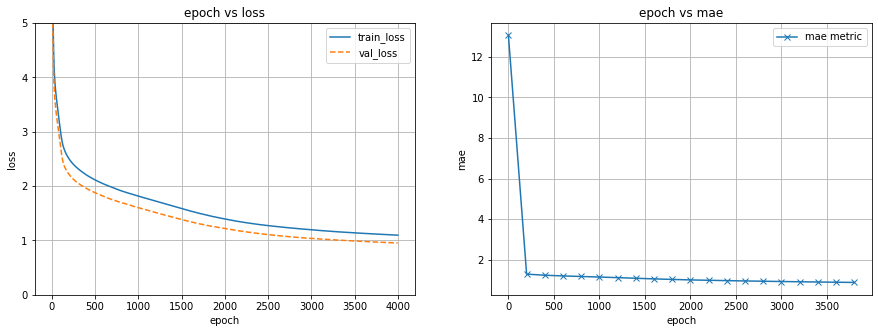

In [ ]:
fig = plt.figure(figsize=(15,5))

# ====== Loss Fluctuation ====== #
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(list_epoch, list_train_loss, label='train_loss')
ax1.plot(list_epoch, list_val_loss, '--', label='val_loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.set_ylim(0, 5)
ax1.grid()
ax1.legend()
ax1.set_title('epoch vs loss')
#이걸 왜 구해야 하냐?
#training 과정이 어떻게 됐는지에 대한 정보를 얻을 수 있기 때문에
#loss를 저장하고 출력하는 습관을 가지자


# ====== Metric Fluctuation ====== #
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(list_mae_epoch, list_mae, marker='x', label='mae metric')

ax2.set_xlabel('epoch')
ax2.set_ylabel('mae')
ax2.grid()
ax2.legend()
ax2.set_title('epoch vs mae')


plt.show()